In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.stats import norm, truncnorm
import time

0.0118 seconds to run with 10 samples


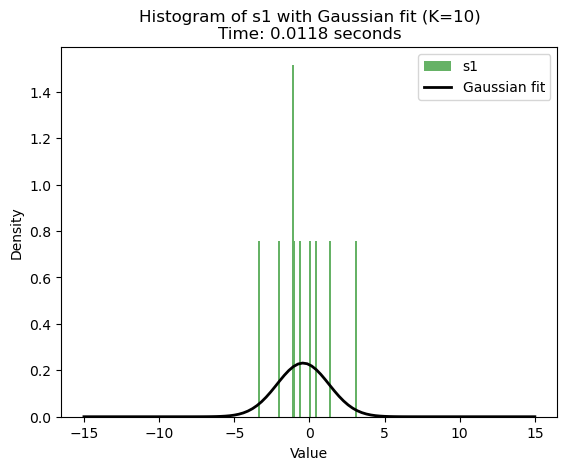

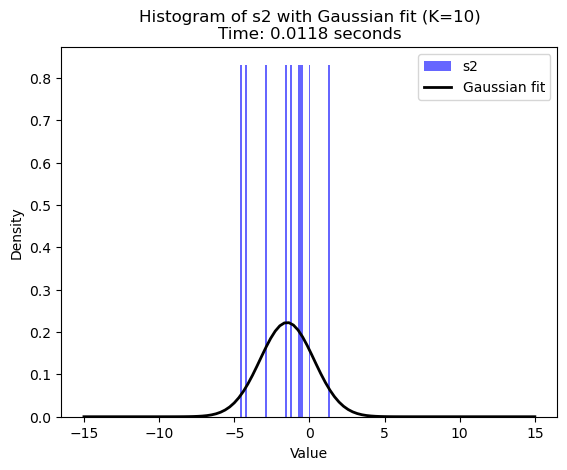

0.0472 seconds to run with 100 samples


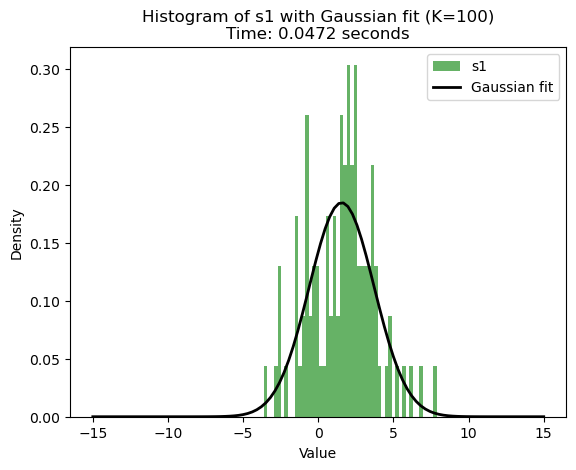

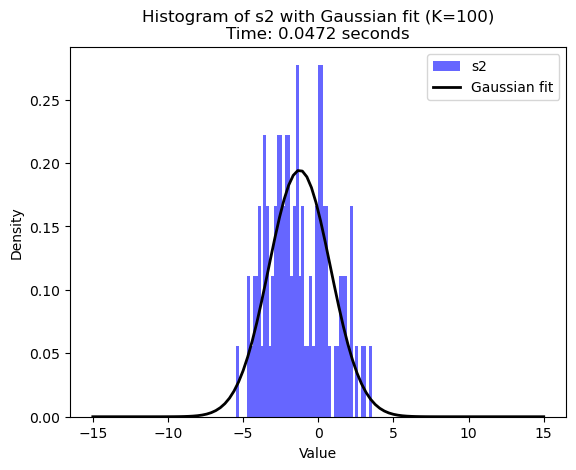

0.2683 seconds to run with 1000 samples


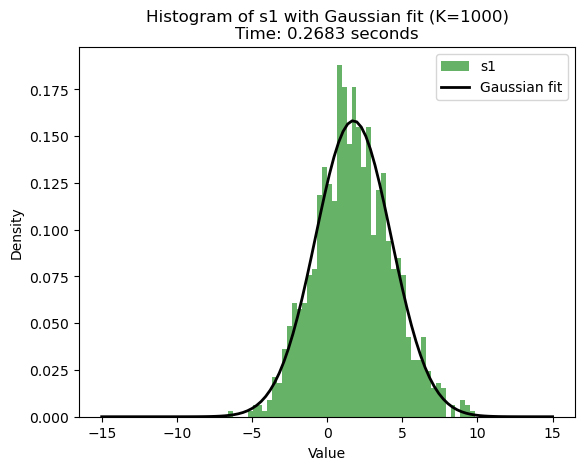

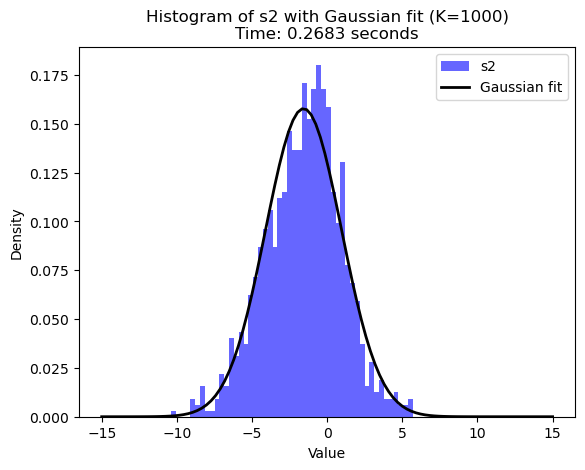

2.5110 seconds to run with 10000 samples


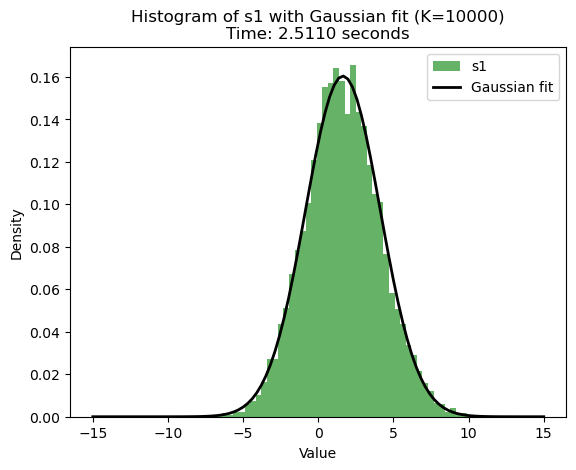

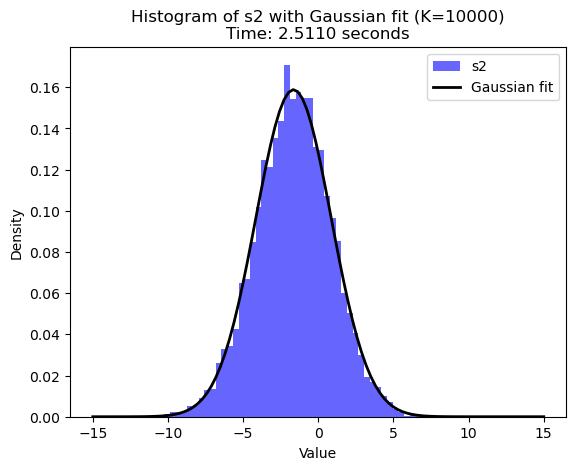

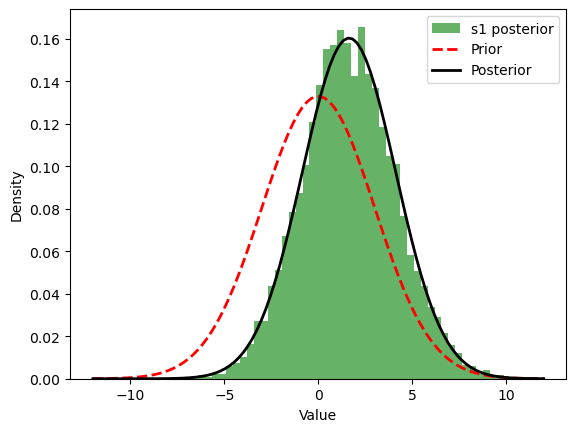

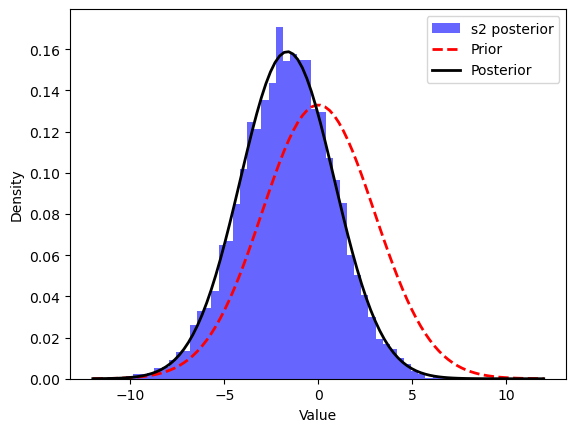

In [2]:
"""
Task 4

"""

def gibbs_sampling(mu1, sigma1, mu2, sigma2, sigma3, K):

    M = np.array([[1, -1]])

    mu = np.array([[mu1], [mu2]])  
    sigmaA = np.array([[sigma1**2, 0], [0, sigma2**2]])
    sigmaAB = np.linalg.inv(np.linalg.inv(sigmaA) + (1 / sigma3**2) * np.transpose(M) @ M)

    myclip_a = 0
    myclip_b = 1000
    my_std = sigma3

    # Gibbs sampling
    s1 = np.zeros(K)
    s2 = np.zeros(K)
    t = np.zeros(K)
    s1[0] = mu1
    s2[0] = mu2

    for k in range(K-1):
        muAB = sigmaAB @ (np.linalg.inv(sigmaA) @ mu + (1 / sigma3**2) * np.transpose(M) @ np.array([[t[k]]]))
        muAB2 = np.ravel(muAB)  # Flatten the array to 1D
        s1[k+1], s2[k+1] = np.random.multivariate_normal(muAB2, sigmaAB)
        my_mean = s1[k+1] - s2[k+1]
        a, b = (myclip_a - my_mean) / my_std, (myclip_b - my_mean) / my_std
        t[k+1] = truncnorm.rvs(a, b, loc=my_mean, scale=my_std)

    # Calculate parameters
    mu_s1 = np.mean(s1)
    std_s1 = np.std(s1)
    mu_s2 = np.mean(s2)
    std_s2 = np.std(s2)

    return s1, s2, mu_s1, std_s1, mu_s2, std_s2

def plot_histogram_and_fit(s1, s2, mu1, sigma1, mu2, sigma2, K, time_elapsed):
    # Parameters for plotting
    x_s1 = np.linspace(mu1 - 5 * sigma1, mu1 + 5 * sigma1, 100)
    x_s2 = np.linspace(mu2 - 5 * sigma2, mu2 + 5 * sigma2, 100)

    mu_s1 = np.mean(s1)
    std_s1 = np.std(s1)
    S1 = norm.pdf(x_s1, mu_s1, std_s1)

    mu_s2 = np.mean(s2)
    std_s2 = np.std(s2)
    S2 = norm.pdf(x_s2, mu_s2, std_s2)

    # Plot s1 histogram and Gaussian fit
    plt.hist(s1, bins=50, density=True, alpha=0.6, color='g', label="s1")
    plt.plot(x_s1, S1, 'k', linewidth=2, label="Gaussian fit")
    plt.title(f"Histogram of s1 with Gaussian fit (K={K})\nTime: {time_elapsed:.4f} seconds")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

    # Plot s2 histogram and Gaussian fit
    plt.hist(s2, bins=50, density=True, alpha=0.6, color='b', label="s2")
    plt.plot(x_s2, S2, 'k', linewidth=2, label="Gaussian fit")
    plt.title(f"Histogram of s2 with Gaussian fit (K={K})\nTime: {time_elapsed:.4f} seconds")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.legend()
    plt.show()




# Initial parameters
sigma1, sigma2, sigma3 = 3, 3, 1
mu1, mu2 = 0, 0

# Values of K to test
Ks = [10, 100, 1000, 10000]

for K in Ks:
    time_start = time.perf_counter()
    s1, s2, _, _, _, _   = gibbs_sampling(mu1, sigma1, mu2, sigma2, sigma3, K)
    time_elapsed = time.perf_counter() - time_start
    print(f"{time_elapsed:.4f} seconds to run with {K} samples")
    plot_histogram_and_fit(s1, s2, mu1, sigma1, mu2, sigma2, K, time_elapsed)



# Plotting posteriors and priors
def plot_posterior_vs_prior(s, prior_mu, prior_sigma, label, color):
    # Posterior parameters
    mu_post = np.mean(s)
    sigma_post = np.std(s)

    # Prior distribution
    x = np.linspace(prior_mu - 4 * prior_sigma, prior_mu + 4 * prior_sigma, 100)
    prior = norm.pdf(x, prior_mu, prior_sigma)

    # Posterior distribution
    posterior = norm.pdf(x, mu_post, sigma_post)

    # Plot
    plt.hist(s, bins=50, density=True, alpha=0.6, color=color, label=f"{label} posterior")
    plt.plot(x, prior, 'r--', linewidth=2, label="Prior")
    plt.plot(x, posterior, 'k-', linewidth=2, label="Posterior")
    # plt.title(f"Posterior vs Prior of {label} (K={K})")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

# Plot posterior vs prior for s1 and s2
plot_posterior_vs_prior(s1, mu1, sigma1, "s1", 'g')
plot_posterior_vs_prior(s2, mu2, sigma2, "s2", 'b')

In [3]:
"""
Task 5

"""


def gibbs_sampling_T5(mu1, sigma1, mu2, sigma2, sigma3):
    """
    Wrapper function for gibbs_sampling to use a fixed number of samples (5000).

    Parameters:
    mu1, sigma1, mu2, sigma2, sigma3: Means and standard deviations of the prior distributions.

    Returns:
    mu_s1, std_s1, mu_s2, std_s2: Means and standard deviations of the sampled values.
    """
    K = 1000
    s1, s2, mu_s1, std_s1, mu_s2, std_s2 = gibbs_sampling(mu1, sigma1, mu2, sigma2, sigma3, K)
    return (mu_s1, std_s1, mu_s2, std_s2)



def update_team_skills(data):
    """
    Update team skills based on match outcomes.

    Parameters:
    data: DataFrame containing match data.

    Returns:
    team_list: Dictionary with updated team skills.
    df: DataFrame with sorted team skills and ranks.
    """
    teams = data['team1'].drop_duplicates()
    team_list = {team: (0, 5) for team in teams}

    for i in range(data.shape[0]):
        score_diff = data.iloc[i]['score1'] - data.iloc[i]['score2']
        if score_diff != 0:
            winner = data.iloc[i]['team1'] if score_diff > 0 else data.iloc[i]['team2']
            loser = data.iloc[i]['team2'] if score_diff > 0 else data.iloc[i]['team1']
            mu1, sigma1, mu2, sigma2 = gibbs_sampling_T5(
                team_list[winner][0], team_list[winner][1],
                team_list[loser][0], team_list[loser][1], sigma3
            )
            team_list[winner] = (mu1, sigma1)
            team_list[loser] = (mu2, sigma2)

    df = pd.DataFrame.from_dict(team_list, orient='index', columns=['Skill', 'Standard Deviation'])
    df.sort_values(by='Skill', ascending=False, inplace=True)
    df['Rank'] = range(1, len(df) + 1)

    return team_list, df

# Load data
data_unshuffled = pd.read_csv("SerieA.csv")  # Unshuffled data
data_shuffled = pd.read_csv("SerieA.csv").sample(frac=1).reset_index(drop=True)  # Shuffled data

N = 5
df_unshuffled_list = []
df_shuffled_list = []
for i in range(N):
    team_list_unshuffled, df_unshuffled = update_team_skills(data_unshuffled)
    team_list_shuffled, df_shuffled = update_team_skills(data_shuffled)
    df_unshuffled_list.append(df_unshuffled)
    df_shuffled_list.append(df_shuffled)
    print("\nUnshuffled Data Team List time",i,": \n", df_unshuffled)
    print("Shuffled Data Team List time ",i,":\n", df_shuffled)
    



Unshuffled Data Team List time 0 : 
                Skill  Standard Deviation  Rank
Atalanta    1.112484            0.372266     1
Milan       0.909998            0.438086     2
Torino      0.844303            0.407278     3
Napoli      0.825653            0.489011     4
Inter       0.683131            0.379733     5
Roma        0.552771            0.403013     6
Juventus    0.178245            0.530702     7
Bologna     0.141215            0.393618     8
Lazio       0.105748            0.401468     9
Udinese    -0.096298            0.424962    10
Spal       -0.144835            0.364158    11
Sampdoria  -0.257166            0.373847    12
Empoli     -0.298417            0.388388    13
Genoa      -0.511429            0.463858    14
Cagliari   -0.563233            0.380512    15
Parma      -0.740456            0.399539    16
Fiorentina -0.960406            0.426658    17
Sassuolo   -0.976787            0.571584    18
Frosinone  -1.216913            0.432507    19
Chievo     -1.811392  

In [4]:
"""

Task 6

"""

def ADF_predict(mu1, sigma1, mu2, sigma2):
    L = 1000  # number of samples
    sigma3 = 3

    # Generate L samples from normal distributions for both teams
    s1 = np.random.normal(mu1, sigma1, L)
    s2 = np.random.normal(mu2, sigma2, L)
    
    # Calculate the mean difference between samples
    mean_diff = s1 - s2  
    
    t = np.random.normal(loc=mean_diff, scale=sigma3, size=L)  
    
    # Take the mean of the samples
    mean_t = np.mean(t)
    
    # Determine the sign of the mean (1 if positive, -1 if negative)
    y = np.sign(mean_t)
    
    return y

def initialize_team_list(data):
    # Get unique team names
    teams = data['team1'].drop_duplicates()
    
    # Initialize team ratings with a mean of 0 and standard deviation of 5
    team_list = {team: (0, 5) for team in teams}
    
    return team_list

def update_team_ratings(data, team_list):
    """
    Returns a list of the mean and variance of each team's skill after the 2018/2019 season.
    """
    ADF_predicted_list = []
    # Iterate over each match in the dataset
    for i in range(data.shape[0]):
        score = data.iloc[i]['score1'] - data.iloc[i]['score2']
        
        # Predict the match result based on current team ratings
        y = ADF_predict(team_list[data.iloc[i]['team1']][0], team_list[data.iloc[i]['team1']][1],
                team_list[data.iloc[i]['team2']][0], team_list[data.iloc[i]['team2']][1])
        
        ADF_predicted_list.append(y)
        
        # Update team ratings based on match result
        if score > 0:
            winner = data.iloc[i]['team1']
            loser = data.iloc[i]['team2']
        elif score < 0:
            winner = data.iloc[i]['team2']
            loser = data.iloc[i]['team1']
        else:
            continue  # Skip draws for rating updates

        mu1, sigma1, mu2, sigma2 = gibbs_sampling_T5(team_list[winner][0], team_list[winner][1],
                                                     team_list[loser][0], team_list[loser][1],sigma3 = 3)
        
        # Update the ratings for both the winner and loser
        team_list[winner] = [mu1, sigma1]
        team_list[loser] = [mu2, sigma2]
    
    return team_list, ADF_predicted_list

def true_results(data):
    """
    Return the list of the true results
    """
    true_result = list()
    draw = 0
    # Calculate the actual match results
    score = data['score1'] - data['score2']
    for i in range(data.shape[0]):
        if score[i] > 0:
            true_result.append(1)
        elif score[i] < 0:
            true_result.append(-1)
        else:
            true_result.append(0)
            draw += 1
    return true_result


def compare_result(prediction, data):
    """
    Print number of correct predictions and prediction rate using ADF
    """
    true_result = true_results(data)
    count = 0
   
    # Convert lists to numpy arrays for element-wise comparison
    true_result = np.array(true_result)
    prediction = np.array(prediction)
    # Compare predictions with actual results
    count_list = (true_result == prediction)
    count = np.sum(count_list)

    total_matches = data.shape[0]
    pred_rate = count / total_matches
    
    # Print the results
    # print("Predict Result:", count_list)
    print("Number of correct predictions:", count)
    print("Prediction rate:", pred_rate)
    first_half = count_list[:total_matches//2]
    second_half = count_list[total_matches//2:]
    print("Prediction rate of the first half season:", sum(first_half)/len(first_half))
    print("Prediction rate of the second half season:", sum(second_half)/len(second_half))
    return count_list

def compare_naive_guess_result(data):
    """
    Print number of correct predictions and prediction rate using naive guess
    """
    true_result = true_results(data)
    true_result = np.array(true_result)
    # Naive guess with P(team 1 win) = P(team 2 win) = 1/2
    naive_guess = np.where(np.random.rand(true_result.size) < 0.5, -1, 1)
    count = np.sum(true_result == naive_guess)
    total_matches = data.shape[0]
    pred_rate = count / total_matches
    print("Number of correct predictions using naive guess:", count)
    print("Prediction rate using naive guess:", pred_rate)

    


data = pd.read_csv("SerieA.csv") 

# Initialize the team list
team_list = initialize_team_list(data)

# Update team ratings based on match data and generate predictions
team_list, ADF_predicted_list = update_team_ratings(data, team_list)

# Compare the prediction results with actual data
predict_list = compare_result(ADF_predicted_list, data)

compare_naive_guess_result(data)

Number of correct predictions: 178
Prediction rate: 0.46842105263157896
Prediction rate of the first half season: 0.45263157894736844
Prediction rate of the second half season: 0.4842105263157895
Number of correct predictions using naive guess: 129
Prediction rate using naive guess: 0.3394736842105263


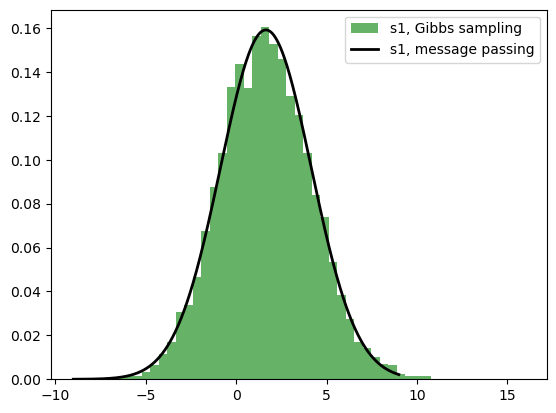

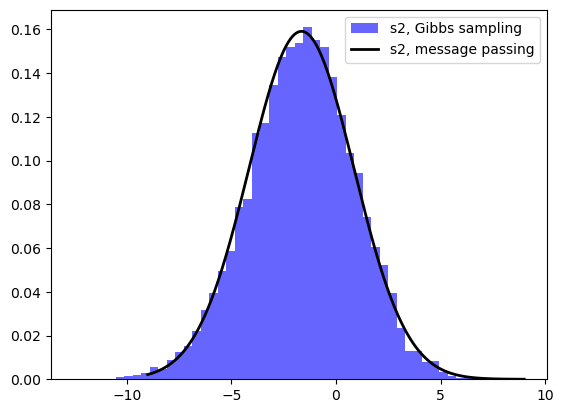

In [5]:
"""

Task 7

"""


def multiplyGauss(m1, s1, m2, s2):
    """
    Multiplies two Gaussian distributions.

    Parameters:
    m1 (float): Mean of the first Gaussian distribution.
    s1 (float): Variance of the first Gaussian distribution.
    m2 (float): Mean of the second Gaussian distribution.
    s2 (float): Variance of the second Gaussian distribution.

    Returns:
    m (float): Mean of the resulting Gaussian distribution after multiplication.
    s (float): Variance of the resulting Gaussian distribution after multiplication.
    """
    # Calculate the variance of the resulting Gaussian distribution
    s = 1 / (1 / s1 + 1 / s2)
    # Calculate the mean of the resulting Gaussian distribution
    m = (m1 / s1 + m2 / s2) * s
    return m, s

def divideGauss(m1, s1, m2, s2):
    """
    Divides two Gaussian distributions.

    Parameters:
    m1 (float): Mean of the first Gaussian distribution.
    s1 (float): Variance of the first Gaussian distribution.
    m2 (float): Mean of the second Gaussian distribution.
    s2 (float): Variance of the second Gaussian distribution.

    Returns:
    m (float): Mean of the resulting Gaussian distribution after division.
    s (float): Variance of the resulting Gaussian distribution after division.
    """
    # Calculate the variance of the resulting Gaussian distribution
    s = 1 / (1 / s1 - 1 / s2)
    # Calculate the mean of the resulting Gaussian distribution
    m = (m1 / s1 - m2 / s2) * s
    return m, s

def truncGauss(my_a, my_b, m1, s1):
    """
    Calculates the mean and variance of a truncated Gaussian distribution.

    Parameters:
    my_a (float): Lower truncation point.
    my_b (float): Upper truncation point.
    m1 (float): Mean of the original Gaussian distribution.
    s1 (float): Variance of the original Gaussian distribution.

    Returns:
    m (float): Mean of the truncated Gaussian distribution.
    s (float): Variance of the truncated Gaussian distribution.
    """
    # Calculate the parameters for the truncated normal distribution
    a, b = (my_a - m1) / np.sqrt(s1), (my_b - m1) / np.sqrt(s1)
    # Compute the mean of the truncated normal distribution
    m = truncnorm.mean(a, b, loc=m1, scale=np.sqrt(s1))
    # Compute the variance of the truncated normal distribution
    s = truncnorm.var(a, b, loc=m1, scale=np.sqrt(s1))
    return m, s


# Defining the 5 hyperparameters
# y0 = 1 indicates that player 1 won a game
mu1 = 0
mu2 = 0
v1 = 3**2
v2 = 3**2
v3 = 1**2
y0 = 1
K = 10000

s1, s2, mu1_Gibbs, sigma1_Gibbs, mu2_Gibbs, sigma2_Gibbs   = gibbs_sampling(mu1, np.sqrt(v1), mu2,  np.sqrt(v2), np.sqrt(v3), K)


#Compute mu5 and v5
mu5 = mu1 - mu2
v5 = v1 + v2 + v3

# Do moment matching of the marginal of t
if y0==1:
    a, b = 0, 20000
else:
    a, b = -20000, 0

#Turning the truncated Gaussian into a Gaussian
mu, v = truncGauss(a,b,mu5,v5)

#Compute mu9 and v9
mu9, v9 = divideGauss(mu,v,mu5,v5)

#Compute mu10 and v10
mu10, v10 = mu2 + mu9, v2 + v3 + v9
#Compute mu11 and v11
mu11, v11 = mu1 - mu9, v1 + v3 + v9

# Compute the marginal of s1 and s2
mu_s1, v_s1 = multiplyGauss(mu1,v1,mu10,v10)
mu_s2, v_s2 = multiplyGauss(mu2,v2,mu11,v11)

#--------MAKING THE PLOT------
#Parameters
L = 1000 #number of samples
x = np.linspace(mu1-v1, mu1+v1, 1000)



#Making pdf:s
s1_pdf = norm.pdf(x, mu_s1, np.sqrt(v_s1))
s2_pdf = norm.pdf(x, mu_s2, np.sqrt(v_s2))

#Make a plot
plt.hist(s1, label="s1, Gibbs sampling", bins =50, density=True, alpha=0.6, color='g')
plt.plot(x, s1_pdf, linewidth=2, label="s1, message passing", color='black')
plt.legend()
plt.show()
plt.hist(s2, label="s2, Gibbs sampling", bins =50, density=True, alpha=0.6, color='b')
plt.plot(x, s2_pdf, linewidth=2, label="s2, message passing", color='black')
plt.legend()
plt.show()

In [12]:
"""

Task 10

"""
alpha = 0.15
beta = 0.05

data_2017_2018 = pd.read_csv("SerieA-2017-2018.csv")
data = pd.read_csv("SerieA.csv") 

def gibbs_sampling_T10(mu1, sigma1, mu2, sigma2, myclip_a, myclip_b):
    """
    Perform Gibbs sampling to estimate posterior distributions.

    Parameters:
    mu1, sigma1, mu2, sigma2: Means and standard deviations of the prior distributions.
    K: Number of samples.

    Returns:
    s1, s2: Arrays of sampled values.
    mu_s1, std_s1, mu_s2, std_s2: Means and standard deviations of the sampled values.
    """
    M = np.array([[1, -1]])
    sigma3 = 1
    K = 1000

    mu = np.array([[mu1], [mu2]])  # Ensure mu is a column vector
    sigmaA = np.array([[sigma1**2, 0], [0, sigma2**2]])
    sigmaAB = np.linalg.inv(np.linalg.inv(sigmaA) + (1 / sigma3**2) * np.transpose(M) @ M)


    my_std = sigma3

    # Gibbs sampling
    s1 = np.zeros(K)
    s2 = np.zeros(K)
    t = np.zeros(K)
    s1[0] = mu1
    s2[0] = mu2

    for k in range(K-1):
        muAB = sigmaAB @ (np.linalg.inv(sigmaA) @ mu + (1 / sigma3**2) * np.transpose(M) @ np.array([[t[k]]]))
        muAB2 = np.ravel(muAB)  # Flatten the array to 1D
        s1[k+1], s2[k+1] = np.random.multivariate_normal(muAB2, sigmaAB)
        my_mean = s1[k+1] - s2[k+1]
        a, b = (myclip_a - my_mean) / my_std, (myclip_b - my_mean) / my_std
        t[k+1] = truncnorm.rvs(a, b, loc=my_mean, scale=my_std)

    # Calculate parameters
    mu_s1 = np.mean(s1)
    std_s1 = np.std(s1)
    mu_s2 = np.mean(s2)
    std_s2 = np.std(s2)

    return mu_s1, std_s1, mu_s2, std_s2



def predict_T10(mu1, sigma1, mu2, sigma2):
    L = 100  # number of samples
    sigma3 = 1

    # Generate L samples from normal distributions for both teams
    s1 = np.random.normal(mu1, sigma1, L)
    s2 = np.random.normal(mu2, sigma2, L)
    
    # Calculate the mean difference between samples
    mean_diff = s1 - s2  
    
    t = np.random.normal(loc=mean_diff, scale=sigma3, size=L)  
    
    # Take the mean of the samples
    mean_t = np.mean(t)
    
    # Determine the sign of the mean (1 if positive, -1 if negative)
    y = np.sign(mean_t + alpha)/2 + np.sign(mean_t - alpha)/2
    
    return y




def get_prior(rank):
    if rank <= 20:
        return 2 - 0.25 * (rank - 1), 1

    


def initialize_team_list_T10(data, data_priors):
    # Get unique team names
    teams = data['team1'].drop_duplicates()
    team_list = {}
    for _, row in data_2017_2018.iterrows():
        team_list[row['Team']] = get_prior(row['Rank'])
    new_teams = set(teams) - set(team_list.keys())
    team_list_items = list(team_list.items())[:-3]
    team_list = dict(team_list_items)
    for team in new_teams:
        team_list[team] = (-3, 3)
    
    
    return team_list

def update_team_ratings_T10(data, team_list):
    predict_list = []
    # Iterate over each match in the dataset
    for i in range(data.shape[0]):
        score = data.iloc[i]['score1'] - data.iloc[i]['score2']
        
        # Predict the match result based on current team ratings
        y = predict_T10(team_list[data.iloc[i]['team1']][0] + beta, team_list[data.iloc[i]['team1']][1],
                team_list[data.iloc[i]['team2']][0], team_list[data.iloc[i]['team2']][1])
        
        predict_list.append(y)
        
        # Update team ratings based on match result
        if score > 0:
            winner = data.iloc[i]['team1']
            loser = data.iloc[i]['team2']
            mu1, sigma1, mu2, sigma2 = gibbs_sampling_T10(team_list[winner][0], team_list[winner][1],
                                                     team_list[loser][0], team_list[loser][1],
                                                     myclip_a = alpha, myclip_b = 1000)
        elif score < 0:
            winner = data.iloc[i]['team2']
            loser = data.iloc[i]['team1']
            mu1, sigma1, mu2, sigma2 = gibbs_sampling_T10(team_list[winner][0], team_list[winner][1],
                                                     team_list[loser][0], team_list[loser][1],
                                                     myclip_a = alpha, myclip_b = 1000)
        else:
            team1 = data.iloc[i]['team1']
            team2 = data.iloc[i]['team2']
            mu1, sigma1, mu2, sigma2 = gibbs_sampling_T10(team_list[team1][0], team_list[team1][1], 
                                                         team_list[team2][0], team_list[team2][1],
                                                        myclip_a=-alpha, myclip_b=alpha)


        # Update the ratings in the team list
        if score != 0:
            team_list[winner] = [mu1, sigma1]
            team_list[loser] = [mu2, sigma2]
        else:  # For draw case, both teams are updated
            team_list[team1] = [mu1, sigma1]
            team_list[team2] = [mu2, sigma2]
    
    return team_list, predict_list


team_list = initialize_team_list_T10(data, data_2017_2018)


# Update team ratings based on match data and generate predictions
team_list, predict_list = update_team_ratings_T10(data, team_list)

# Compare the prediction results with actual data
predict_result, true_result = compare_result(predict_list, data)

Number of correct predictions: 202
Prediction rate: 0.531578947368421
